In [2]:
import hashlib
import os
import tarfile
import zipfile
from sched import scheduler
import requests
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import DataLoader

In [3]:
# 读取数据集
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
all_features = pd.read_csv('all_features.csv')

In [4]:
# 我们将数据集内的数字类型和object类型分开，进行数据填充和归一化

# 选择所有数值型列（整数和浮点数）
numeric_cols = all_features.select_dtypes(include=['number']).columns

# 对数值型列的缺失值用中位数填充
all_features[numeric_cols] = all_features[numeric_cols].fillna(all_features[numeric_cols].median())

# 选择所有对象类型列
object_cols = all_features.select_dtypes(include=['object']).columns

# 对每个分类列处理缺失值
for col in object_cols:
    # 用该列的众数填充缺失值
    # mode()[0] 获取第一个众数（可能有多个值出现频率相同）
    all_features[col].fillna(all_features[col].mode()[0], inplace=True)

# 创建标准化器对象（用于数值特征标准化）
scaler = StandardScaler()

# 再次选择数值型特征（确保包含所有处理后的数值列）
numeric_features = all_features.select_dtypes(include=['float64', 'int64'])

# 对数值特征进行标准化（缩放至均值为0，标准差为1）
all_features[numeric_features.columns] = scaler.fit_transform(numeric_features)

In [5]:
# 进行独热编码
print(f'原始特征维度：{all_features.shape[1]}')
all_features = pd.get_dummies(all_features, dummy_na=True)
print(f'独热编码后的特征维度：{all_features.shape[1]}')

原始特征维度：24
独热编码后的特征维度：63


In [6]:
# 获取训练集的样本数量
n_train = train_data.shape[0]

# 创建训练特征张量：
# 1. 从预处理后的all_features中提取前n_train行（训练集部分）
# 2. 获取NumPy数组表示并转换为浮点类型
# 3. 创建PyTorch张量，指定数据类型为float32
# 4. 将张量移动到指定设备（GPU或CPU）
train_features = torch.tensor(all_features[:n_train].values.astype(float),
                              dtype=torch.float32).to(device)

# 创建测试特征张量：
# 1. 从预处理后的all_features中提取n_train行之后的数据（测试集部分）
# 2. 获取NumPy数组表示并转换为浮点类型
# 3. 创建PyTorch张量，指定数据类型为float32
# 4. 将张量移动到指定设备（GPU或CPU）
test_features = torch.tensor(all_features[n_train:].values.astype(float),
                             dtype=torch.float32).to(device)

In [7]:
# 获取训练标签
train_labels = torch.tensor(train_data['Sold Price'].values.reshape(-1,1),
                            dtype=torch.float32).to(device)

In [8]:
# 创建数据加载器 (DataLoader) 用于批量处理特征数据:
# 1. all_features: 包含所有预处理特征的DataFrame(此时应为Tensor或Dataset类型)
# 2. batch_size=64: 每个批次包含64个样本
# 3. shuffle=True: 每次迭代前打乱数据顺序(增强训练随机性)
# 4. num_workers=4: 使用4个子进程并行加载数据(加速数据准备)
# 5. pin_memory=True: 将数据固定到内存中(当使用GPU时可加速CPU到GPU的数据传输)
all_features = DataLoader(all_features, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

In [9]:
# 训练
loss = nn.MSELoss()  # 定义损失函数
in_features = train_features.shape[1]  # 训练时输入的特征维度

In [10]:
def get_net():
    """
    创建并返回一个多层感知机(MLP)神经网络模型
    
    网络结构:
        输入层 -> 隐藏层1 (128个神经元) -> BatchNorm1d -> ReLU激活 -> Dropout -> 
        隐藏层2 (64个神经元) -> BatchNorm1d -> ReLU激活 -> 输出层 (1个神经元)
    
    返回:
        nn.Sequential: 包含定义网络层的序列容器
    """
    net = nn.Sequential(
        # 第一个全连接层：从输入特征到128个神经元的隐藏层
        nn.Linear(in_features, 128),   # in_features: 输入特征维度
        
        # 批量归一化层：对128维特征进行归一化处理，加速训练并提高稳定性
        nn.BatchNorm1d(128),
        
        # ReLU激活函数：引入非线性，保留正数输出，负数置零
        nn.ReLU(),
        
        # Dropout层：训练时以0.3概率随机丢弃神经元，防止过拟合
        nn.Dropout(0.3),
        
        # 第二个全连接层：128个神经元到64个神经元的隐藏层
        nn.Linear(128, 64),
        
        # 批量归一化层：对64维特征进行归一化
        nn.BatchNorm1d(64),
        
        # ReLU激活函数
        nn.ReLU(),
        
        # 输出层：64个神经元到1个输出值（回归问题预测单一数值）
        nn.Linear(64, 1)
    )
    return net

In [11]:
def log_rmse(net, features, labels):
    """
    计算对数均方根误差(Log Root Mean Square Error)评估模型性能
    
    参数:
        net: 神经网络模型
        features: 输入特征张量
        labels: 真实标签张量
    
    返回:
        float: 对数均方根误差值
    
    处理步骤:
        1. 使用模型进行预测，并限制预测值在[1, ∞)范围内(防止取对数时出现负数或0)
        2. 同样限制真实标签值在[1, ∞)范围内
        3. 对预测值和标签值取自然对数
        4. 计算对数后的均方误差(MSE)
        5. 取均方误差的平方根得到均方根误差(RMSE)
    """
    
    # 限制预测值在[1, ∞)范围内 - 防止取对数时出现无效值(负数和0)
    clipped_preds = torch.clamp(net(features), 1, float('inf'))  # float('inf')表示无穷大
    
    # 限制真实标签值在[1, ∞)范围内
    clipped_labels = torch.clamp(labels, min=1)
    
    # 计算对数均方根误差:
    # 1. 对预测值和标签值取自然对数(压缩数据范围，使大值和小值对损失的影响更均衡)
    # 2. 计算对数后的均方误差(MSE)
    # 3. 取均方误差的平方根得到均方根误差(RMSE)
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(clipped_labels)))
    
    # 返回标量值(从张量中提取Python浮点数)
    return rmse.item()

In [12]:
def train(net, train_features, train_labels, test_features, test_labels,
         num_epochs, learning_rate, weight_decay, batch_size):
    """
    训练神经网络模型并记录训练/验证损失
    
    参数:
        net: 神经网络模型
        train_features: 训练集特征
        train_labels: 训练集标签
        test_features: 验证集特征(可选)
        test_labels: 验证集标签(可选)
        num_epochs: 训练轮数
        learning_rate: 初始学习率
        weight_decay: L2正则化系数
        batch_size: 批次大小
    
    返回:
        train_ls: 每轮训练损失记录列表
        test_ls: 每轮验证损失记录列表(若有验证集)
    """
    
    # 初始化损失记录列表
    train_ls, test_ls = [], []
    
    # 创建数据迭代器，将特征和标签组合并按批次加载
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    
    # 创建优化器(Adam)，设置学习率和权重衰减(L2正则化)
    optimizer = torch.optim.Adam(net.parameters(), 
                                 lr=learning_rate, 
                                 weight_decay=weight_decay)
    
    # 创建学习率调度器(当验证损失连续10轮不下降时，学习率减半)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',      # 监控指标应该最小化
        factor=0.5,      # 学习率衰减因子
        patience=10      # 容忍轮数(连续10轮无改善则降低学习率)
    )
    
    # 开始训练循环
    for epoch in range(num_epochs):
        # 设置为训练模式(启用Dropout/BatchNorm等训练特定行为)
        net.train()  
        
        # 批量训练
        for X, y in train_iter:
            # 将数据移动到对应设备(GPU/CPU)
            X, y = X.to(device), y.to(device)
            
            # 清除之前的梯度
            optimizer.zero_grad()
            
            # 前向传播计算损失
            l = loss(net(X), y)
            
            # 反向传播计算梯度
            l.backward()
            
            # 梯度裁剪(防止梯度爆炸，限制梯度范数不超过1.0)
            torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
            
            # 更新模型参数
            optimizer.step()
        
        # 计算并记录整个训练集的损失
        train_ls.append(log_rmse(net, train_features, train_labels))
        
        # 如果提供了验证集
        if test_labels is not None:
            # 设置为评估模式(禁用Dropout/BatchNorm使用运行统计)
            net.eval()  
            
            # 关闭梯度计算(节省内存，加速推理)
            with torch.no_grad():  
                # 计算并记录验证集损失
                test_ls.append(log_rmse(net, test_features, test_labels))
                
                # 根据最新验证损失调整学习率
                scheduler.step(test_ls[-1])  # 使用验证集损失调整学习率
    
    # 返回训练和验证损失记录
    return train_ls, test_ls

In [13]:
def get_k_fold_data(k, i, X, y):
    """
    生成K折交叉验证中指定折的训练集和验证集
    
    参数:
        k: 总折数
        i: 当前作为验证集的折索引(0 ≤ i < k)
        X: 完整特征数据集
        y: 完整标签数据集
    
    返回:
        X_train: 训练集特征(包含除第i折外的所有数据)
        y_train: 训练集标签
        X_valid: 验证集特征(第i折数据)
        y_valid: 验证集标签
    
    说明:
        1. 将数据集分成k个相等的折(每折大小 = 数据总量//k)
        2. 指定第i折作为验证集
        3. 其余k-1折合并作为训练集
    """
    
    # 确保折数k至少为2(否则无法分割为训练集和验证集)
    assert k > 1
    
    # 计算每折的数据量(使用整数除法)
    fold_size = X.shape[0] // k
    
    # 初始化训练集和验证集
    X_train, y_train = None, None
    X_valid, y_valid = None, None
    
    # 遍历所有k折
    for j in range(k):
        # 计算当前折的索引切片范围
        idx = slice(j * fold_size, (j + 1) * fold_size)
        
        # 提取当前折的特征和标签
        X_part, y_part = X[idx, :], y[idx]
        
        # 当前折是目标验证折
        if j == i:
            X_valid, y_valid = X_part, y_part
            
        # 当首次遇到非验证折时初始化训练集    
        elif X_train is None:
            X_train, y_train = X_part, y_part
            
        # 将后续非验证折合并到训练集
        else:
            # 沿第一个维度(样本维度)拼接数据
            X_train = torch.cat([X_train, X_part], dim=0)
            y_train = torch.cat([y_train, y_part], dim=0)
            
    # 返回训练集和验证集
    return X_train, y_train, X_valid, y_valid

In [14]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    """
    执行K折交叉验证评估模型性能
    
    参数:
        k: 交叉验证折数
        X_train: 完整训练集特征
        y_train: 完整训练集标签
        num_epochs: 每个模型的训练轮数
        learning_rate: 学习率
        weight_decay: L2正则化系数
        batch_size: 批次大小
    
    返回:
        train_l_sum/k: 平均训练损失
        valid_l_sum/k: 平均验证损失
    
    处理流程:
        1. 对每折数据训练一个新模型
        2. 记录每折的最终训练和验证损失
        3. 可视化第一折的训练过程
        4. 计算所有折的平均性能
    """
    
    # 初始化训练和验证损失总和
    train_l_sum, valid_l_sum = 0, 0
    
    # 遍历每一折
    for i in range(k):
        print(f'========== 处理第 {i+1}/{k} 折 ==========')
        
        # 获取当前折的训练集和验证集
        # data 包含 (X_train_fold, y_train_fold, X_valid_fold, y_valid_fold)
        data = get_k_fold_data(k, i, X_train, y_train)
        
        # 创建新的网络实例并移动到设备
        net = get_net().to(device)
        
        # 解包数据并训练模型
        # *data 将元组拆分为四个参数传递给train函数
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        
        # 累加最后一轮的训练损失(最终训练损失)
        train_l_sum += train_ls[-1]
        # 累加最后一轮的验证损失(最终验证损失)
        valid_l_sum += valid_ls[-1]
        
        # 仅对第一折绘制训练过程
        if i == 0:
            # 绘制训练损失和验证损失曲线
            d2l.plot(
                list(range(1, num_epochs + 1)),  # x轴: 训练轮次
                [train_ls, valid_ls],            # y轴: 训练和验证损失值
                xlabel='epoch',                   # x轴标签
                ylabel='rmse',                   # y轴标签
                xlim=[1, num_epochs],            # x轴范围
                legend=['train', 'valid'],        # 图例
                yscale='log'                     # y轴使用对数刻度
            )
        
        # 打印当前折的结果
        print(f'折 {i+1} - 训练对数RMSE: {train_ls[-1]:.6f}, 验证对数RMSE: {valid_ls[-1]:.6f}')
    
    # 计算并返回平均训练损失和平均验证损失
    return train_l_sum / k, valid_l_sum / k

========== 处理第 1/5 折 ==========
折 1 - 训练对数RMSE: 0.342596, 验证对数RMSE: 0.292951
========== 处理第 2/5 折 ==========
折 2 - 训练对数RMSE: 0.346080, 验证对数RMSE: 0.368935
========== 处理第 3/5 折 ==========
折 3 - 训练对数RMSE: 0.333847, 验证对数RMSE: 0.306270
========== 处理第 4/5 折 ==========
折 4 - 训练对数RMSE: 0.374394, 验证对数RMSE: 0.370800
========== 处理第 5/5 折 ==========
折 5 - 训练对数RMSE: 0.337329, 验证对数RMSE: 0.462893


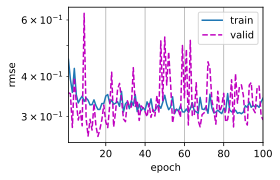

In [15]:
# 定义参数
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)

In [16]:
def train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size):
    """
    训练最终模型并在测试集上进行预测，生成提交文件
    
    参数:
        train_features: 完整训练集特征
        test_features: 测试集特征
        train_labels: 训练集标签
        test_data: 原始测试集DataFrame(包含ID列)
        num_epochs: 训练轮数
        lr: 学习率
        weight_decay: L2正则化系数
        batch_size: 批次大小
    
    处理流程:
        1. 创建并训练最终模型
        2. 绘制训练损失曲线
        3. 在测试集上进行预测
        4. 生成并保存提交文件
    """
    
    # 创建神经网络模型实例并移动到指定设备
    net = get_net().to(device)
    
    # 训练模型(不使用验证集)
    # 返回训练损失列表(train_ls)和空验证损失列表(_)
    train_ls, _ = train(net, 
                        train_features, 
                        train_labels, 
                        None,   # 测试特征(无验证集)
                        None,   # 测试标签(无验证集)
                        num_epochs, 
                        lr, 
                        weight_decay, 
                        batch_size)
    
    # 绘制训练损失变化曲线
    d2l.plot(np.arange(1, num_epochs + 1),  # x轴: 训练轮次
             [train_ls],                    # y轴: 训练损失值
             xlabel='epoch',                # x轴标签
             ylabel='log rmse',             # y轴标签
             xlim=[1, num_epochs],          # x轴范围
             yscale='log')                 # y轴使用对数刻度
    
    # 打印最终训练损失
    print(f'最终训练对数RMSE: {float(train_ls[-1]):f}')
    
    # 在测试集上进行预测
    # 1. 模型推理(禁用梯度计算)
    # 2. 分离计算图(detach)
    # 3. 从GPU移回CPU
    # 4. 转换为NumPy数组
    preds = net(test_features).detach().cpu().numpy()
    
    # 将预测结果添加到测试集DataFrame:
    # 1. 将预测结果展平为一维数组
    # 2. 创建Pandas Series
    # 3. 添加到test_data作为'Sold Price'列
    test_data['Sold Price'] = pd.Series(preds.reshape(1, -1)[0])
    
    # 创建提交文件:
    # 1. 选择ID列和预测的价格列
    # 2. 按列拼接(axis=1)
    submission = pd.concat([test_data['Id'], test_data['Sold Price']], axis=1)
    
    # 保存提交文件为CSV(不保存索引列)
    submission.to_csv('submission.csv', index=False)
    
    print("提交文件已保存为 'submission.csv'")

最终训练对数RMSE: 0.386006
提交文件已保存为 'submission.csv'


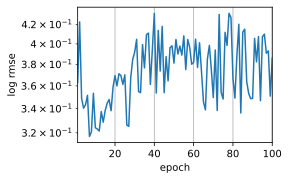

In [17]:
# 训练最终模型并在测试集上进行预测，生成提交文件
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)